In [1]:
import pandas as pd
import os
from autorank import autorank, plot_stats, create_report, latex_table
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 25)
import matplotlib.pyplot as plt

In [2]:
def parse_gct(filename, out_csv):
    # print(filename)
    file = filename.split('/')[-1]
    STRact = 1 if 'STR' in filename else 0
    prunemethod = ""
    if 'LRU' in file:
        if "Oza" in file:
            prunemethod = "Oza"
        if STRact:
            prunemethod += 'LRUSTR'
        else:
            prunemethod += 'LRU'
    elif 'LFU' in file:
        if STRact:
            prunemethod += 'LFUSTR'
        else:
            prunemethod += 'LFU'
    else:
        prunemethod = file.split('-')[0]
    if 'g50' not in filename:
        grace_period = 200
    else:
        grace_period = 50
        prunemethod += 'g'
    if 'c005' not in filename:
        split_confidence = 0.0000001
    else:
        split_confidence = 0.05
        prunemethod += 'c'
    if 't01' not in filename:
        tie_threshold = 0.05
    else:
        tie_threshold = 0.1
        prunemethod += 't'
    if 'MC' in filename:
        leafAlg='MC'
    else:
        leafAlg='NBA'

    # pruneactive = 1 if 'prune' in file.split('-')[0] else 0
    dataset = '.'.join(file.split('.')[0:-1]).split('-')[-1]
    if dataset == 'MC' or 'iter' in dataset:
        dataset = '.'.join(file.split('.')[0:-1]).split('-')[-2]
    # print(file,prunemethod,dataset)
    
    df = pd.read_csv(filename)
    # display(df.tail(1))
    wanted = ['evaluation time (cpu seconds)', 'evaluationTime', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)', 'model serialized size (bytes)',
              'tree size (nodes)', 'tree size (leaves)', 'tree depth', 'INTERVAL', 
              'THRESHOLD (depth 0)', 'PRUNED', 'PRUNE-SPLIT', 'PRUNE-LEARN', 'AVG-NODESIZE', 'MAX-NODESIZE']
    for i in range(len(wanted)):
        w = wanted[i]
        if w not in df.columns:
            if w == 'AVG-NODESIZE' or w == 'MAX-NODESIZE':
                wanted[i] = f'[avg] {w}'
                if wanted[i] not in df.columns:
                    df[wanted[i]] = 0
            else:
                df[w] = 0
    plist = [dataset, prunemethod, leafAlg] + list(df[wanted].tail(1).values.flatten().tolist())
    # if prunemethod == 'HT' and (grace_period != 200 or tie_threshold != 0.05 or split_confidence != 0.0000001):
    #     return
    pstr = ''
    for i in plist:
        pstr += f"{i},"
    # print(pstr[:-1])
    out_csv.write(f"{pstr[:-1]}\n")
    # Dataset, pruning active, 'prune method', time, acc, prec, recall, model size (bytes), tree nodes, 
    # tree leaves, tree depth, interval, Pruning threshold, total pruned, split pruned, learn pruned

In [3]:
def print_res_gct(RESDIR):
    out_csv = 'output.csv'
    with open(out_csv,"w+") as of:
        of.write('Dataset,prune_method,leafAlg,time,evaluationTime,acc,prec,recall,model_size_(bytes),tree_nodes,tree_leaves,tree_depth,interval,pruning_threshold,total_pruned,split_pruned,learn_pruned,avg_size,max_size\n')
        for f in os.listdir(RESDIR):
            if 'term' not in f:
                parse_gct(f"{RESDIR}/{f}", of)
                # break
    df = pd.read_csv('output.csv')
    print("lines:",len(df))
    # print(df.dtypes)
    df = df [['Dataset','prune_method','leafAlg','interval','pruning_threshold','time','evaluationTime','acc','prec','recall','tree_depth','total_pruned','split_pruned','learn_pruned','avg_size','max_size']]
    df = df.sort_values(by=['Dataset','prune_method','interval','pruning_threshold'])
    # df = df[(df.pruning_threshold == 0) | (df.pruning_threshold == 600)]
    # df = df[()]
    # df = df.groupby(by=['Dataset','prune_method','interval','pruning_threshold','leafAlg'],as_index=False).mean()
    # print(df.to_csv(index=False))
    return df

In [4]:
RESDIR='ICDE/ICDE-results-ensembles-synthethic/'
df = print_res_gct(RESDIR)

lines: 5610


In [5]:
print(df.Dataset.unique(), len(df.Dataset.unique()))

['AGR' 'AGR_a' 'AGR_g' 'HPlane' 'HPlane_f' 'HPlane_m' 'HPlane_s' 'LED'
 'LED_a' 'LED_g' 'RBF' 'RBF_f' 'RBF_m' 'RBF_s' 'RTG' 'Wave' 'Wform_d5n'] 17


In [6]:
df.prune_method = df.prune_method.str.replace("HRAPTr", "RAP-HT")
df.prune_method.unique()

array(['EFDT', 'RAP-HT', 'HT', 'HTconf', 'HTct', 'HTtie'], dtype=object)

In [7]:
drift_data = ['AGR_a', 'AGR_g', 'HPlane_f', 'HPlane_m', 'HPlane_s', 'LED_a', 'LED_g', 'RBF_f', 'RBF_m', 'RBF_s', 'Wform_d5n']
non_drift_data = ['AGR', 'HPlane', 'LED', 'RBF', 'RTG', 'Wave']
real_data = ['GMSC', 'airlines', 'covtypeNorm', 'elecNormNew', 'nomao']

In [8]:
for ds in df.Dataset.unique():
    adf = df[df.Dataset == ds]
    # print()
    print(f"{ds:10} {adf.acc.min():0.6f} {adf.acc.max():0.6f}   - {len(df[df.interval == 2000])}   {len(df[df.interval == 10000])}  {len(df[df.interval == 500])}")


AGR        94.855300 95.075800   - 0   0  0
AGR_a      84.971100 93.132700   - 0   0  0
AGR_g      80.180400 89.732100   - 0   0  0
HPlane     74.647200 91.321600   - 0   0  0
HPlane_f   72.371700 91.755300   - 0   0  0
HPlane_m   74.758600 90.990900   - 0   0  0
HPlane_s   74.982400 91.372200   - 0   0  0
LED        58.327700 74.081100   - 0   0  0
LED_a      45.830200 71.691200   - 0   0  0
LED_g      45.533100 71.571500   - 0   0  0
RBF        86.397900 96.349100   - 0   0  0
RBF_f      54.151000 68.319700   - 0   0  0
RBF_m      61.194100 85.877200   - 0   0  0
RBF_s      79.162800 91.828200   - 0   0  0
RTG        78.054800 93.551800   - 0   0  0
Wave       74.580400 86.007300   - 0   0  0
Wform_d5n  74.557800 85.917400   - 0   0  0


In [9]:
megadf = df[(df.prune_method == 'RAP-HT') & (df.leafAlg == 'NBA')].groupby(by=['Dataset','prune_method','interval','pruning_threshold'], as_index=False)
allHR = megadf[['time','acc','avg_size','max_size','total_pruned']].agg(['mean','std'])
allHR

time             \
                                                         mean        std   
Dataset   prune_method interval pruning_threshold                          
AGR       RAP-HT       0.0      0.0                 38.813006   2.739153   
AGR_a     RAP-HT       0.0      0.0                 96.306811  10.803625   
AGR_g     RAP-HT       0.0      0.0                123.051328  12.687856   
HPlane    RAP-HT       0.0      0.0                162.761996  17.181889   
HPlane_f  RAP-HT       0.0      0.0                172.449221  21.874870   
HPlane_m  RAP-HT       0.0      0.0                167.287750  19.409909   
HPlane_s  RAP-HT       0.0      0.0                159.668600  19.136718   
LED       RAP-HT       0.0      0.0                158.701666  28.587898   
LED_a     RAP-HT       0.0      0.0                257.909786  39.677901   
LED_g     RAP-HT       0.0      0.0                256.272825  52.819688   
RBF       RAP-HT       0.0      0.0                106.883744  24.177420   
RBF_f     RAP-HT       0.0      0.0                121.999389  20.671660   
RBF_m     RAP-HT       0.0      0.0                133.668852  22.140966   
RBF_s     RAP-HT       0.0      0.0                133.562330  16.177319   
RTG       RAP-HT       0.0      0.0                133.277111   9.471083   
Wave      RAP-HT       0.0      0.0                192.168059  35.640039   
Wform_d5n RAP-HT       0.0      0.0                304.224298  59.343097   

                                                         acc            \
                                                        mean       std   
Dataset   prune_method interval pruning_threshold                        
AGR       RAP-HT       0.0      0.0                95.026593  0.021617   
AGR_a     RAP-HT       0.0      0.0                92.918277  0.160239   
AGR_g     RAP-HT       0.0      0.0                89.334253  0.186737   
HPlane    RAP-HT       0.0      0.0                90.612787  0.280185   
HPlane_f  RAP-HT       0.0      0.0                86.760100  2.275288   
HPlane_m  RAP-HT       0.0      0.0                90.380863  0.306757   
HPlane_s  RAP-HT       0.0      0.0                90.590640  0.274534   
LED       RAP-HT       0.0      0.0                73.977127  0.041216   
LED_a     RAP-HT       0.0      0.0                69.605230  0.186857   
LED_g     RAP-HT       0.0      0.0                69.366693  0.122750   
RBF       RAP-HT       0.0      0.0                93.534793  1.150514   
RBF_f     RAP-HT       0.0      0.0                67.888060  0.218447   
RBF_m     RAP-HT       0.0      0.0                85.121123  0.300350   
RBF_s     RAP-HT       0.0      0.0                91.482590  0.147492   
RTG       RAP-HT       0.0      0.0                92.385820  0.155797   
Wave      RAP-HT       0.0      0.0                85.648727  0.077220   
Wform_d5n RAP-HT       0.0      0.0                85.584273  0.072872   

                                                     avg_size             \
                                                         mean        std   
Dataset   prune_method interval pruning_threshold                          
AGR       RAP-HT       0.0      0.0                 53.141958   4.527709   
AGR_a     RAP-HT       0.0      0.0                235.142472   9.574452   
AGR_g     RAP-HT       0.0      0.0                313.462851  15.202339   
HPlane    RAP-HT       0.0      0.0                340.149752   2.075756   
HPlane_f  RAP-HT       0.0      0.0                376.737532  29.060583   
HPlane_m  RAP-HT       0.0      0.0                342.535201   2.965984   
HPlane_s  RAP-HT       0.0      0.0                340.450158   1.715950   
LED       RAP-HT       0.0      0.0                 51.430299   1.036325   
LED_a     RAP-HT       0.0      0.0                103.662874   2.727339   
LED_g     RAP-HT       0.0      0.0                104.451687   3.022211   
RBF       RAP-HT       0.0      0.0                213.802492  16.4

In [10]:
allHR.reset_index(inplace=True)
allHR['new_id'] =  allHR['prune_method'] + '-' + allHR['pruning_threshold'].astype(str) + '-' + allHR['interval'].astype(str)
allHR.set_index('new_id', drop=False, inplace=True)
allHR.drop(['prune_method', 'interval','pruning_threshold'], axis=1, inplace=True)

print('total pruned')
pivoted = allHR.pivot(index='Dataset', columns='new_id')[('total_pruned','mean')]
display(pivoted)

print('runtime')
pivoted = allHR.pivot(index='Dataset', columns='new_id')[('time','mean')]
display(pivoted)
display(pivoted.describe())
# print(df.groupby(by=['prune_method','leafAlg'],as_index=False).mean().to_csv(index=False))

total pruned


/var/folders/kg/qpcy2xws4vq6p37_l6cgt9r80000gn/T/ipykernel_28618/3881561659.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  allHR.drop(['prune_method', 'interval','pruning_threshold'], axis=1, inplace=True)


new_id,RAP-HT-0.0-0.0
Dataset,
AGR,0.0
AGR_a,0.0
AGR_g,0.0
HPlane,0.0
HPlane_f,0.0
HPlane_m,0.0
HPlane_s,0.0
LED,0.0
LED_a,0.0


runtime


new_id,RAP-HT-0.0-0.0
Dataset,
AGR,38.813006
AGR_a,96.306811
AGR_g,123.051328
HPlane,162.761996
HPlane_f,172.449221
HPlane_m,167.287750
HPlane_s,159.668600
LED,158.701666
LED_a,257.909786


new_id,RAP-HT-0.0-0.0
count,17.000000
mean,159.941575
std,64.897884
min,38.813006
25%,123.051328
50%,158.701666
75%,172.449221
max,304.224298


column = group
row = observation

In [11]:
df.prune_method.unique()

array(['EFDT', 'RAP-HT', 'HT', 'HTconf', 'HTct', 'HTtie'], dtype=object)

In [12]:
df.pruning_threshold = df.pruning_threshold.astype(int)
df.pruning_threshold.unique()

array([0])

In [13]:
df.interval = df.interval.astype(int)
df.interval = df.interval.astype(str)
df.interval = df.interval.str.replace('10000','10k')
df.interval = df.interval.str.replace('000','k')
df.interval.unique()

array(['0'], dtype=object)

---


### filter bad HRAPTr out

In [14]:
hdf = df[(~df.prune_method.isin(['HRAPTrgct', 'EFDTgct', 'HTgct', 'HAT']))]
print(hdf.prune_method.unique())

['EFDT' 'RAP-HT' 'HT' 'HTconf' 'HTct' 'HTtie']


In [15]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# create report by measures

In [16]:
def create_report_measure(df, measure, using_autorank=True, ascending=True, display_measure_tables=False, display_ranks_tables=False, display_static=False, display_drift=False, filename=None):
    print("reports for measure:", measure)
    resultdf=pd.DataFrame()
    autorankdf=pd.DataFrame()
    ranksdf=pd.DataFrame()
    for ds in df.Dataset.unique():
        adf = df[(df.Dataset == ds) & (df.leafAlg == 'NBA')].copy()
        rdf = adf.groupby(by=['prune_method','pruning_threshold','interval'],as_index=False)[['time', 'evaluationTime', 'acc','avg_size', 'max_size', 'total_pruned']].agg(['mean','std'])
        ardf = adf.groupby(by=['prune_method','pruning_threshold','interval'],as_index=False)[['time', 'evaluationTime', 'acc','avg_size', 'max_size', 'total_pruned']].mean()
        ranksrdf = ardf.copy()
        ranksrdf['ranks'] = ranksrdf[measure].rank(ascending=ascending, method='first')
        rdf = rdf.reset_index()
        ardf = ardf.reset_index()
        ranksrdf.reset_index()
        rdf['new_id'] = rdf['prune_method']
        # + '-' + rdf['pruning_threshold'].astype(str) + '-' + rdf['interval'].astype(str)
        ardf['new_id'] = ardf['prune_method']
        # + '-' + ardf['pruning_threshold'].astype(str) + '-' + ardf['interval'].astype(str)
        ranksrdf['new_id'] = ranksrdf['prune_method']
        # + '-' + ranksrdf['pruning_threshold'].astype(str) + '-' + ranksrdf['interval'].astype(str)
        rdf['Dataset'] = ds
        ardf['Dataset'] = ds
        ranksrdf['Dataset'] = ds
        rdf = rdf.set_index('new_id', drop=False)
        ardf = ardf.set_index('new_id', drop=False)
        ranksrdf = ranksrdf.set_index('new_id', drop=False)
        drdf = rdf.pivot(index='new_id', columns='Dataset')[(measure,'mean')]
        dardf = ardf.pivot(index='new_id', columns='Dataset')[measure]
        dranksrdf = ranksrdf.pivot(index='new_id', columns='Dataset')['ranks']
        # display(drdf)
        resultdf = pd.concat([resultdf,drdf], axis=1)
        autorankdf = pd.concat([autorankdf,dardf], axis=1)
        ranksdf = pd.concat([ranksdf, dranksrdf], axis=1)
        
        
    if display_measure_tables:
        full = resultdf.transpose()
        print("full")
        display(full)
        display(full.describe())
        if display_static:
            static = resultdf[['AGR', 'HPlane', 'LED', 'RBF', 'RTG', 'Wave']].sort_index(level=1, axis=1).transpose()
            print('static')
            display(static)
            display(static.describe())
        if display_drift:
            drift = resultdf[['AGR_a', 'AGR_g' , 'HPlane_f', 'HPlane_m', 'HPlane_s', 'LED_a', 'LED_g', 'RBF_f', 'RBF_m', 'RBF_s']].sort_index(level=1, axis=1).transpose()
            print('drift')
            display(drift)
            display(drift.describe())

    if display_ranks_tables:
        static = ranksdf[['AGR', 'HPlane', 'LED', 'RBF', 'RTG', 'Wave']].sort_index(level=1, axis=1).transpose()
        drift = ranksdf[['AGR_a', 'AGR_g' , 'HPlane_f', 'HPlane_m', 'HPlane_s', 'LED_a', 'LED_g', 'RBF_f', 'RBF_m', 'RBF_s']].sort_index(level=1, axis=1).transpose()
        print("full")
        display(ranksdf.transpose())
        display(ranksdf.transpose().describe())
        if display_static:
            print('static')
            display(static)
            display(static.describe())
        if display_drift:
            print('drift')
            display(drift)
            display(drift.describe())
    
    if using_autorank:
        order = 'ascending' if ascending else 'descending'
        print(order)
        results = autorank(autorankdf.transpose(), alpha=0.05, verbose=True, order=order, force_mode='nonparametric')
        display(results[0])
        fig, maxi = plt.subplots()
        plot_stats(results, allow_insignificant=True, ax=maxi)
        if filename != None:
            plt.savefig(f'{filename}.png')
        create_report(results)


In [17]:
hdf = df[~(df.prune_method.isin(['HRAPTrgct', 'EFDTgct', 'HTgct', 'HTct', ]))]
hdf = hdf[(hdf.interval == '0') | ((hdf.pruning_threshold == 5) & (hdf.interval == '2k'))]
print(hdf.prune_method.unique())
measure_tables = False
drift_tables = False
static_tables = False

['EFDT' 'RAP-HT' 'HT' 'HTconf' 'HTtie']


reports for measure: acc
descending
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column EFDT (p=0.151725>=0.010000)
Fail to reject null hypothesis that data is normal for column HT (p=0.011533>=0.010000)
Fail to reject null hypothesis that data is normal for column HTconf (p=0.013464>=0.010000)
Fail to reject null hypothesis that data is normal for column HTtie (p=0.020035>=0.010000)
Rejecting null hypothesis that data is normal for column RAP-HT (p=0.002896<0.010000)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.999212>=0.050000)
Using Friedman test as omnibus test
Fail to reject null hypothesis that there is no difference between the distributions (p=0.714131)


,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude
new_id,,,,,,,
HTtie,3.352941,86.833180,3.985423,70.018407,95.02043,0.0,negligible
HTconf,3.235294,86.743450,4.313587,69.257367,95.025283,0.014574,negligible
HT,2.882353,86.737500,4.738663,69.017843,95.026307,0.01474,negligible
EFDT,2.823529,85.943347,4.725127,70.969353,95.03802,0.137312,negligible
RAP-HT,2.705882,89.334253,3.685527,69.366693,95.026593,-0.439493,small


The statistical analysis was conducted for 5 populations with 17 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population RAP-HT (p=0.003). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.479 of the Nemenyi test.
We failed to reject the null hypothesis (p=0.714) of the Friedman test that there is no differ

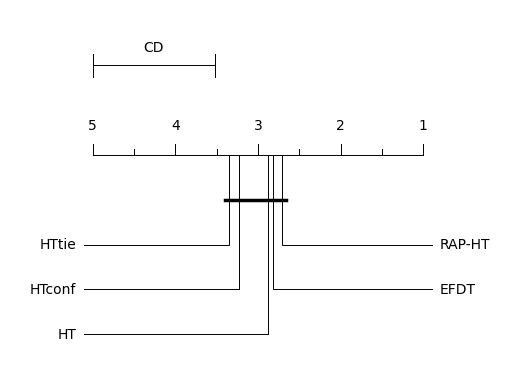

In [18]:
create_report_measure(hdf, 'acc', using_autorank=True, ascending=False, display_measure_tables=measure_tables, display_drift=drift_tables, display_static=static_tables, filename='RAP-HT_ens_acc')

reports for measure: time
ascending
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column EFDT (p=0.276504>=0.010000)
Fail to reject null hypothesis that data is normal for column HT (p=0.268523>=0.010000)
Fail to reject null hypothesis that data is normal for column HTconf (p=0.129311>=0.010000)
Rejecting null hypothesis that data is normal for column HTtie (p=0.005535<0.010000)
Fail to reject null hypothesis that data is normal for column RAP-HT (p=0.259598>=0.010000)
Using Levene's test for homoscedacity of non-normal data.
Rejecting null hypothesis that all variances are equal (p=0.000001<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.


,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude
new_id,,,,,,,
HTtie,1.117647,93.623800,13.815025,79.808775,229.928115,0.0,negligible
HTconf,2.588235,141.497705,19.464329,94.745063,297.481732,-1.913203,large
RAP-HT,3.000000,158.701666,33.466393,96.306811,304.224298,-1.714538,large
HT,3.529412,155.776767,27.024037,100.891745,325.204593,-1.953381,large
EFDT,4.764706,448.206195,143.312244,93.284063,1030.509745,-2.34918,large


The statistical analysis was conducted for 5 populations with 17 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population HTconf (p=0.006). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.479 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in th

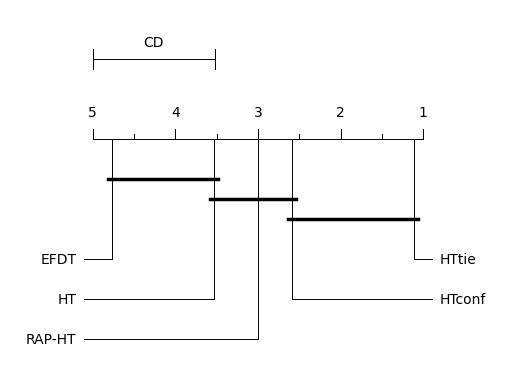

In [19]:
create_report_measure(hdf, 'time', using_autorank=True, ascending=True, display_measure_tables=measure_tables, display_drift=drift_tables, display_static=static_tables, filename='RAP-HT_ens_time')

reports for measure: avg_size
ascending
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column EFDT (p=0.165724>=0.010000)
Fail to reject null hypothesis that data is normal for column HT (p=0.199348>=0.010000)
Fail to reject null hypothesis that data is normal for column HTconf (p=0.247690>=0.010000)
Fail to reject null hypothesis that data is normal for column HTtie (p=0.037979>=0.010000)
Fail to reject null hypothesis that data is normal for column RAP-HT (p=0.151415>=0.010000)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.076679>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical dis

,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude
new_id,,,,,,,
HTtie,1.352941,105.332222,59.652222,70.282887,213.283126,0.0,negligible
RAP-HT,2.647059,216.567103,112.115415,142.42984,296.994698,-0.741524,medium
HTconf,2.705882,272.230000,110.542222,156.21628,353.02006,-0.929338,large
EFDT,3.882353,246.992927,95.063611,156.457828,420.515474,-0.97885,large
HT,4.411765,345.154444,139.701111,194.903696,431.251075,-1.242437,large


The statistical analysis was conducted for 5 populations with 17 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.038). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.077) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we should use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. However, the user decided to force the use of the less powerful Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We report the mean value (M), the standard deviation (SD) and the m

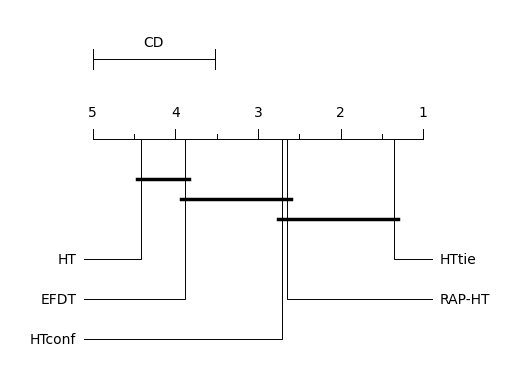

In [20]:
create_report_measure(hdf, 'avg_size', using_autorank=True, ascending=True, display_measure_tables=measure_tables, display_drift=drift_tables, display_static=static_tables, filename='RAP-HT_ens_avg_size')

reports for measure: max_size
ascending
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Fail to reject null hypothesis that data is normal for column EFDT (p=0.149627>=0.010000)
Fail to reject null hypothesis that data is normal for column HT (p=0.199348>=0.010000)
Fail to reject null hypothesis that data is normal for column HTconf (p=0.247690>=0.010000)
Fail to reject null hypothesis that data is normal for column HTtie (p=0.037979>=0.010000)
Fail to reject null hypothesis that data is normal for column RAP-HT (p=0.156285>=0.010000)
Using Bartlett's test for homoscedacity of normally distributed data
Fail to reject null hypothesis that all variances are equal (p=0.074292>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical dis

,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude
new_id,,,,,,,
HTtie,1.411765,207.664444,119.304444,137.565773,423.566253,0.0,negligible
RAP-HT,2.529412,373.128889,173.384444,254.606694,564.380235,-0.612707,medium
HTconf,2.823529,541.460000,221.084444,309.43256,703.04012,-0.929338,large
EFDT,3.823529,487.035556,199.524444,301.231733,832.004737,-0.950611,large
HT,4.411765,687.308889,279.402222,386.807393,859.50215,-1.242437,large


The statistical analysis was conducted for 5 populations with 17 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.038). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.074) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we should use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. However, the user decided to force the use of the less powerful Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We report the mean value (M), the standard deviation (SD) and the m

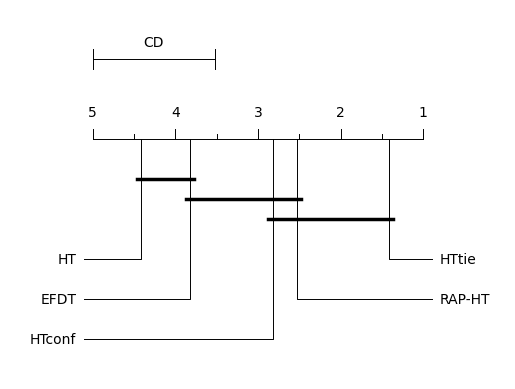

In [21]:
create_report_measure(hdf, 'max_size', using_autorank=True, ascending=True, display_measure_tables=measure_tables, display_drift=drift_tables, display_static=static_tables, filename='RAP-HT_ens_max_size')

---




# Tables for paper


In [22]:
def custom_function(row, ds, two_decimals=True):
    if two_decimals:
        return f"{row[('mean', ds)]:0.2f} \u00B1 {row[('std', ds)]:0.2f}"
    else:
        return f"{row[('mean', ds)]:0.1f} \u00B1 {row[('std', ds)]:0.1f}"

In [23]:
def create_report_paper(df, measure='acc', two_decimals=True):
    drift_data = ['AGR_a', 'AGR_g', 'HPlane_f', 'HPlane_m', 'HPlane_s', 'LED_a', 'LED_g', 'RBF_f', 'RBF_m', 'RBF_s']
    non_drift_data = ['AGR', 'HPlane', 'LED', 'RBF', 'RTG', 'Wave']
    datasets = drift_data + non_drift_data
    resultdf=pd.DataFrame()
    for ds in df.Dataset.unique():
        adf = df[(df.Dataset == ds) & (df.leafAlg == 'NBA')].copy()
        rdf = adf.groupby(by=['prune_method','pruning_threshold','interval'],as_index=False)[['time', 'evaluationTime', 'acc','avg_size','max_size', 'total_pruned']].agg(['mean','std'])
        rdf = rdf.reset_index()
        rdf['new_id'] = rdf['prune_method'] + '-' + rdf['pruning_threshold'].astype(str) + '-' + rdf['interval'].astype(str)
        rdf['Dataset'] = ds
        rdf = rdf.set_index('new_id', drop=False)
        drdf = rdf.pivot(index='new_id', columns='Dataset')[measure]
        resultdf = pd.concat([resultdf,drdf], axis=1)
        
    print("full")
    # display(resultdf)
    mydf = resultdf.copy()
    
    for ds in datasets:
        mydf[('table',ds)] = mydf.apply(lambda x : custom_function(x, ds, two_decimals=two_decimals), axis=1)
    # display(mydf)
    latexdf = mydf.drop(columns=['mean', 'std']).transpose().droplevel(0)
    # print(latexdf.columns)
    print(latexdf.to_latex())

In [24]:
create_report_paper(hdf)

full
\begin{tabular}{llllll}
\toprule
new\_id &      EFDT-0-0 &        HT-0-0 &    HTconf-0-0 &     HTtie-0-0 &    RAP-HT-0-0 \\
Dataset  &               &               &               &               &               \\
\midrule
AGR\_a    &  86.71 ± 0.60 &  91.48 ± 0.10 &  91.06 ± 0.14 &  88.51 ± 0.23 &  92.92 ± 0.16 \\
AGR\_g    &  81.22 ± 0.40 &  86.30 ± 0.14 &  86.02 ± 0.15 &  85.05 ± 0.26 &  89.33 ± 0.19 \\
HPlane\_f &  88.49 ± 1.54 &  86.74 ± 2.29 &  86.74 ± 2.32 &  86.83 ± 2.41 &  86.76 ± 2.28 \\
HPlane\_m &  90.27 ± 0.26 &  90.38 ± 0.31 &  90.42 ± 0.28 &  90.60 ± 0.23 &  90.38 ± 0.31 \\
HPlane\_s &  90.45 ± 0.26 &  90.59 ± 0.27 &  90.62 ± 0.25 &  90.82 ± 0.21 &  90.59 ± 0.27 \\
LED\_a    &  71.10 ± 0.31 &  69.17 ± 0.21 &  69.45 ± 0.25 &  70.49 ± 0.29 &  69.61 ± 0.19 \\
LED\_g    &  70.97 ± 0.32 &  69.02 ± 0.15 &  69.26 ± 0.19 &  70.02 ± 0.23 &  69.37 ± 0.12 \\
RBF\_f    &  65.67 ± 0.17 &  65.10 ± 0.12 &  64.38 ± 0.10 &  60.37 ± 0.12 &  67.89 ± 0.22 \\
RBF\_m    &  82.92 ± 0.16 

/var/folders/kg/qpcy2xws4vq6p37_l6cgt9r80000gn/T/ipykernel_28618/1940228818.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latexdf.to_latex())


In [25]:
create_report_paper(hdf, measure='avg_size', two_decimals=False)

full
\begin{tabular}{llllll}
\toprule
new\_id &      EFDT-0-0 &        HT-0-0 &    HTconf-0-0 &     HTtie-0-0 &    RAP-HT-0-0 \\
Dataset  &               &               &               &               &               \\
\midrule
AGR\_a    &  161.1 ± 10.3 &   368.3 ± 8.2 &   328.7 ± 7.6 &   247.6 ± 6.1 &   235.1 ± 9.6 \\
AGR\_g    &   153.2 ± 9.7 &   607.7 ± 7.1 &   510.9 ± 6.7 &   334.9 ± 7.7 &  313.5 ± 15.2 \\
HPlane\_f &  306.1 ± 50.3 &  380.3 ± 28.7 &  301.7 ± 23.5 &  132.2 ± 22.8 &  376.7 ± 29.1 \\
HPlane\_m &  336.1 ± 20.1 &   345.2 ± 3.3 &   272.2 ± 3.2 &   106.0 ± 5.4 &   342.5 ± 3.0 \\
HPlane\_s &  342.1 ± 15.8 &   343.1 ± 2.0 &   270.5 ± 2.4 &   104.8 ± 4.8 &   340.5 ± 1.7 \\
LED\_a    &   176.2 ± 6.4 &   114.2 ± 3.1 &    90.5 ± 2.7 &    86.9 ± 4.8 &   103.7 ± 2.7 \\
LED\_g    &   174.8 ± 6.3 &   113.4 ± 2.7 &    90.1 ± 2.8 &    87.9 ± 3.5 &   104.5 ± 3.0 \\
RBF\_f    &   381.3 ± 2.4 &   370.2 ± 1.4 &   290.2 ± 1.1 &   105.3 ± 0.7 &   159.4 ± 7.9 \\
RBF\_m    &   724.0 ± 6.2 

/var/folders/kg/qpcy2xws4vq6p37_l6cgt9r80000gn/T/ipykernel_28618/1940228818.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latexdf.to_latex())
